### Assignment 3
## Question 1: Representation Learning for Text Embedding
### [CM1]: 1

In [5]:
import nltk
import warnings
warnings.filterwarnings('ignore') 
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
#pip install gensim 
#pip install datasets
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec, KeyedVectors
import numpy as numpy

In [6]:
#loading "ClimateFever" from datasets library.

from datasets import load_dataset
dataset = load_dataset('climate_fever')

Using custom data configuration default
Reusing dataset climate_fever (C:\Users\saian\.cache\huggingface\datasets\climate_fever\default\1.0.1\3b846b20d7a37bc0019b0f0dcbde5bf2d0f94f6874f7e4c398c579f332c4262c)


In [152]:
#considering "claims" data

dataset
claim_data=dataset['test']['claim']
#claim_data

## Data Preprocessing

Below are the preprocessing steps performed on the data:
1. Converting the text to lower case, removing new lines within a sentence, alphanumeric words, text in <>, http links, characters that are not alphabets, extra spaces.
2. We have performed Lemmatization instead of stemming since stemming just removes the last few characters of a word, often leading to incorrect meanings and spelling. Lemmatization considers the context and converts the word to its meaningful base form.
3. Removed the stop words.

In [8]:
text1=[]
for i in range(len(claim_data)):
    claim_data[i] = claim_data[i].lower() 
    text = re.sub('\n', ' ', claim_data[i])
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text=re.sub('[^abcdefghijklmnopqrstuvwxyz\s]', '',text)
    text = re.sub(r'\s+',' ',text)
    text1.append(text)
    
lemmatizer = WordNetLemmatizer()
for i in range(len(text1)):
    words = nltk.word_tokenize(text1[i])
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    text1[i] = ' '.join(words)  

In [153]:
#text1

In [10]:
# Divding the whole dataset into train and test sets.

x_train, x_test = train_test_split(text1, test_size = 0.2, random_state = 0)

sentences_whole = [nltk.word_tokenize(x) for x in text1]
sentences_train = [nltk.word_tokenize(x) for x in x_train]
sentences_test = [nltk.word_tokenize(x) for x in x_test]
len(sentences_train),len(sentences_test),len(sentences_whole)

(1228, 307, 1535)

In [11]:
# Training the Word2Vec model using the whole dataset( train and test sets) and creating the embeddings

w2v_model = Word2Vec(min_count=1,window=5,size=300)
w2v_model.build_vocab(sentences_whole)
whole_count = len(sentences_whole)
w2v_model.train(sentences_whole, total_examples=whole_count, epochs=5)
words_whole = w2v_model.wv.vocab
text_embed = w2v_model[list(words_whole.keys())]

In [12]:
type(words_whole),type(text_embed),len(text_embed)

(dict, numpy.ndarray, 3827)

In [13]:
whole_dict={}
for i in words_whole:
    whole_dict[i]=w2v_model[i]      

In [14]:
list_words_test=[]
for i in range(len(sentences_test)):    
    list_words_test=list(set(list_words_test+sentences_test[i]))
    
len(list_words_test)

1481

In [154]:
#x_test

In [16]:
#creating the emedding for test dataset

test_embed = w2v_model[list_words_test]
type(list_words_test),type(test_embed),len(test_embed)

(list, numpy.ndarray, 1481)

In [17]:
def cosine_similarity(A: numpy.ndarray, B: numpy.ndarray) -> float:
    '''Calculates the cosine similarity between two arrays

    Args:
       A: a numpy array which corresponds to a word vector
       B: A numpy array which corresponds to a word vector
    Return:
       cos: numerical number representing the cosine similarity between A and B.
    '''
    dot_product = A.dot(B)
    norm_of_A = numpy.linalg.norm(A)
    norm_of_B = numpy.linalg.norm(B)
    cos = dot_product/(norm_of_A * norm_of_B)
    return cos

## Question 1: 
### [CM1]: 2

We considered list of similar context words from the test set and then found what the model says about the similarity of these words using the cosine similarity between the word vectors.

In [18]:
#sentence = 'double atmospheric carbon dioxide wed raise global surface temperature degree celsius'

print("Cosine similarity between 'carbon' " + "and 'global' - CBOW : ", 
    round(w2v_model.similarity('carbon', 'global'),2))

Cosine similarity between 'carbon' and 'global' - CBOW :  0.98


In [19]:
#sentence = 'beginning however polar ice modestly receded several year'

print("Cosine similarity between 'polar' " + "and 'ice' - CBOW : ", 
    round(w2v_model.similarity('polar', 'ice'),2)) 

Cosine similarity between 'polar' and 'ice' - CBOW :  0.94


In [20]:
#sentence = 'global sea level data show sea level rise increasing since future sea level rise prediction based physic statistic' 

print("Cosine similarity between 'sea' " + "and 'rise' - CBOW : ", 
    round(w2v_model.similarity('sea', 'rise'),2))      

Cosine similarity between 'sea' and 'rise' - CBOW :  0.97


In [21]:
#sentence1 = renewables wind turbine environmentally disastrous pollute huge land area slice dice bird bat kill insect bird food 
#create health problem human live within kilometre leave toxin around turbine site despoil landscape

#sentence2 = pluto experience drastic season change due elliptical orbit take earth year'

print("Cosine similarity between 'bat' " +  "and 'pluto' - CBOW : ", 
    round(w2v_model.similarity('bat', 'pluto'),2)) 

Cosine similarity between 'bat' and 'pluto' - CBOW :  0.15


The dataset "climate fever" consists of real-world claims regarding climate-change collected on the internet. 
From the above similarity scores we infer these

1) carbondioxide is the main cause for global warming and that is a known fact and the similarity score between carbon and warming is 98%. This score is high and is as expected because the dataset is about the climate change and the model learned it.

2) When the second pair of words polar and ice are considered, the model gave us a similarity scores of 94%. This is because the two words are similar in the context provided in the dataset.

3) Consider the third example, sea and rise. the model gave us a similarity scores of 97%. This is because the two words are similar in the context provided in the dataset.

4) Considering the fourth example, words bat and pluto are disimilar in general and as expected the similarity score for these by the model is 15%

We are finding the similarities considering skip gram method

In [22]:
# Create Skip Gram model 
model2 = Word2Vec(sentences_whole,min_count=1,window=20,size=100,sg = 1,negative=20)

In [23]:
#sentence = 'double atmospheric carbon dioxide wed raise global surface temperature degree celsius'

print("Cosine similarity between 'global' " + 
               "and 'warming' - SG : ", 
    round(model2.similarity('carbon', 'global'),2))

Cosine similarity between 'global' and 'warming' - SG :  0.96


In [24]:
#sentence = 'beginning however polar ice modestly receded several year'

print("Cosine similarity between 'polar' " + "and 'ice' - SG : ", 
    round(model2.similarity('polar', 'ice'),2)) 

Cosine similarity between 'polar' and 'ice' - SG :  0.97


In [25]:
#sentence = 'global sea level data show sea level rise increasing since future sea level rise prediction based physic statistic' 

print("Cosine similarity between 'sea' " + 
               "and 'rise' - SG : ", 
    round(model2.similarity('sea', 'rise'),2))   

Cosine similarity between 'sea' and 'rise' - SG :  0.99


We notice that skip gram method also gave better cosine similarity for similar context words

In [26]:
#Considering the evidences data to see if the embeddings improve

evid_data=dataset['test']['evidences']
evid_dataset=[]
for i in range(len(evid_data)):
    for j in range(5):
        evid_dataset.append(evid_data[i][j]['evidence'])  

claim_evid = claim_data + evid_dataset
len(claim_evid)

9210

In [27]:
# Data preprocessing

text2=[]
for i in range(len(claim_evid)):
    claim_evid[i] = claim_evid[i].lower() 
    text = re.sub('\n', ' ', claim_evid[i])
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text=re.sub('[^abcdefghijklmnopqrstuvwxyz\s]', '',text)
    text = re.sub(r'\s+',' ',text)
    text2.append(text)
    
lemmatizer = WordNetLemmatizer()
for i in range(len(text2)):
    words = nltk.word_tokenize(text2[i])
    words = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    text2[i] = ' '.join(words) 
    
len(text2)

9210

In [28]:
# Divding the whole dataset into train and test sets.
x_train_ev, x_test_ev = train_test_split(text2, test_size = 0.2, random_state = 0)

sentences_whole_ev = [nltk.word_tokenize(x) for x in text2]
sentences_train_ev = [nltk.word_tokenize(x) for x in x_train_ev]
sentences_test_ev = [nltk.word_tokenize(x) for x in x_test_ev]
len(sentences_train_ev),len(sentences_test_ev),len(sentences_whole_ev)

(7368, 1842, 9210)

In [29]:
# Training the Word2Vec model using the whole dataset( train and test sets) and creating the embeddings

w2v_model_ev = Word2Vec(min_count=1,window=5,size=300)
w2v_model_ev.build_vocab(sentences_whole_ev)
whole_count_ev = len(sentences_whole_ev)
w2v_model_ev.train(sentences_whole_ev, total_examples=whole_count_ev, epochs=5)
words_whole_ev = w2v_model_ev.wv.vocab
text_embed_ev = w2v_model_ev[list(words_whole_ev.keys())]

list_words_test_ev=[]
for i in range(len(sentences_test_ev)):    
    list_words_test_ev=list(set(list_words_test_ev+sentences_test_ev[i]))
    
len(list_words_test_ev)

4960

In [30]:
#Creating the embedding for test set.

test_embed_ev = w2v_model_ev[list_words_test_ev]

In [31]:
print("Cosine similarity between 'carbon' " + 
               "and 'global' - CBOW : ", 
    round(w2v_model_ev.similarity('carbon', 'global'),2))

Cosine similarity between 'carbon' and 'global' - CBOW :  0.68


In [32]:
print("Cosine similarity between 'polar' " + "and 'ice' - CBOW : ", 
    round(w2v_model_ev.similarity('polar', 'ice'),2)) 

Cosine similarity between 'polar' and 'ice' - CBOW :  0.91


In [33]:
print("Cosine similarity between 'sea' " + "and 'rise' - CBOW : ", 
    round(w2v_model_ev.similarity('sea', 'rise'),2)) 

Cosine similarity between 'sea' and 'rise' - CBOW :  0.95


We notice that adding evidences to the corpus is resulting in decrease in cosinesimilarity of the chosen words.

## Question 1: 
### [CM1]: 3

In [34]:
vector1 = w2v_model['carbon'] + w2v_model['emission'] + w2v_model['increase']
w2v_model.wv.most_similar([vector1])

[('emission', 0.9915057420730591),
 ('carbon', 0.9911237955093384),
 ('climate', 0.9882451891899109),
 ('temperature', 0.9875587821006775),
 ('warming', 0.9875039458274841),
 ('global', 0.9867895841598511),
 ('increase', 0.9863797426223755),
 ('year', 0.9863522052764893),
 ('ice', 0.9847619533538818),
 ('level', 0.9843956232070923)]

Analyzing the above arithmetic computation, adding "carbon", "emission" and "increase" embeddings is giving us words warming, temperature, global. Which means that increase in carbon emissions will lead to increase in temperature or global warming

"carbon" + "emission" + "increase" = "temperature"

In [35]:
vector1 = w2v_model['sea'] + w2v_model['level'] + w2v_model['increase']
vector2 = w2v_model['global'] + w2v_model['warming']
a=cosine_similarity(vector1,vector2)
round(a,2)

0.99

The arithmetic computation "sea" + "level" + "increase" = "global" + "warming". This is a fact because global warming melts the ice which causes the increase in sea level.

In [36]:
vector1 = w2v_model['climate'] + w2v_model['greenhouse'] + w2v_model['gas']
w2v_model.wv.most_similar([vector1])

[('climate', 0.9942123889923096),
 ('temperature', 0.98834228515625),
 ('warming', 0.9871240854263306),
 ('year', 0.9857960343360901),
 ('global', 0.9845653772354126),
 ('gas', 0.984207272529602),
 ('level', 0.9834625720977783),
 ('change', 0.9831617474555969),
 ('much', 0.9831477403640747),
 ('ice', 0.9827476739883423)]

The arithmetic computation "climate" + "greenhouse" + "gas" = "temperature". This states that the amount of greenhouse gases in the climate is proportional to temperature. If these gases increase, the temperature would also increase.

In [129]:
vector1 = w2v_model_ev['australia'] - w2v_model_ev['bushfires'] + w2v_model_ev['climate']
vector2 = w2v_model_ev['cool'] 
a=cosine_similarity(vector1,vector2)
round(a,2)

0.93

The arithmetic computation "australia" - "bushfires" + "climate" = "cool". This states that reduction of bushfires in Australia will lead to a cool climate.

In [127]:
vector1 = w2v_model_ev['canada'] - w2v_model_ev['ottawa'] + w2v_model_ev['california']
w2v_model_ev.wv.most_similar([vector1])

[('ring', 0.9996074438095093),
 ('holocene', 0.9995946884155273),
 ('ecological', 0.9995903372764587),
 ('great', 0.9995038509368896),
 ('living', 0.9994794130325317),
 ('bay', 0.9994304776191711),
 ('dynamic', 0.9994274973869324),
 ('mortality', 0.9994268417358398),
 ('affecting', 0.9994043707847595),
 ('coral', 0.9993956089019775)]

In [128]:
vector2 = w2v_model_ev['america'] 
a=cosine_similarity(vector1,vector2)
round(a,2)

1.0

For the fifth arithmetic combination we have chosen word pairs canada,ottawa and america,california. The arithmetic computation is "canada" - "ottawa" + "california" = "america".  "Ottawa" is a place in Canada and California is a place in America, the computation must give us the word America. So we used cosine similarity to verify the computation.

## Question 1: 
### [CM1]: 4

### Comparing the embeddings of our model with pretrained model

In [142]:
#loading pretrained google word2vec model

model_google = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

We are considering the same words used for the arithmetic combinations above to see how well the combinations are correct when pretrained model "GoogleNews-vectors-negative300" is used

In [131]:
vector1 = model_google['carbon'] + model_google['emission'] + model_google['increase']
model_google.wv.most_similar([vector1])

[('emission', 0.8643685579299927),
 ('carbon', 0.84678053855896),
 ('emissions', 0.8128032088279724),
 ('carbon_emission', 0.7959212064743042),
 ('carbon_emissions', 0.7770252227783203),
 ('carbon_dioxide_emissions', 0.7466552257537842),
 ('greenhouse_gas_emissions', 0.7379574179649353),
 ('carbon_dioxide_emission', 0.7319967150688171),
 ('greenhouse_gas', 0.7241928577423096),
 ('CO2_emission', 0.7227335572242737)]

In [132]:
vector1 = model_google['sea'] + model_google['level'] + model_google['increase']
vector2 = model_google['global'] + model_google['warming']
a=cosine_similarity(vector1,vector2)
round(a,2)

0.26

In [47]:
vector1 = model_google['climate'] + model_google['greenhouse'] + model_google['gas']
model_google.wv.most_similar([vector1])

[('greenhouse', 0.7783831357955933),
 ('climate', 0.72782301902771),
 ('gas', 0.611106276512146),
 ('carbon_dioxide', 0.5625354051589966),
 ('CO2', 0.5613980889320374),
 ('greenhouses', 0.5584539175033569),
 ('climate_change', 0.556509256362915),
 ('global_warming', 0.5540904998779297),
 ('greenhouse_gas', 0.5476487874984741),
 ('sulphate_aerosols', 0.5429424047470093)]

In [48]:
vector1 = model_google['australia'] - model_google['bushfires'] + model_google['climate']
vector2 = model_google['cool'] 
a=cosine_similarity(vector1,vector2)
round(a,2)

0.13

In [141]:
vector1 = model_google['canada'] - model_google['ottawa'] + model_google['california']
model_google.most_similar([vector1])

[('california', 0.8382629752159119),
 ('canada', 0.7523062825202942),
 ('usa', 0.6704245805740356),
 ('mexico', 0.6373782157897949),
 ('australia', 0.6313273906707764),
 ('india', 0.603010892868042),
 ('america', 0.5974423885345459),
 ('uk', 0.5972855687141418),
 ('san_francisco', 0.5819123983383179),
 ('europe', 0.5813350677490234)]

1. The first arithmetic combination carbon + emission + increase was giving a word "temperature" when our custom model was used but the same arithmetic combination resulted in "greenhouse_gas_emissions" with the pre-trained model GoogleNews. The custom model was trained on climate dataset and the arithmetic combinations were obtained with respect to the context "climate change". But in real case when pretrained GoogleNews was considered, it resulted in greenhouse_gas_emissions which is equivalent to increase in carbon emission and is true.

2. The combinations sea + level + increase, global +warming were 99% similar in case of the custom model we trained but the pretrained model resulted in only 23% similarity. This might be because, an increase in sea level will not only be due to global warming in reality. Hence the trained model needs more dataset in order to generalize better.

3. For the combination climate + greenshouse + gas the custom model gave the word "temperature" and the pretrained model gave the word "carbondioxide". Since carbondioxide is also a greenhouse gas, the arithmetic combination is valid.

4. The combinations australia - bushfires + climate, cool were 94% similar in case of the custom model we trained but the pretrained model resulted in only 13% similarity. This could be because the custom model has many words/sentences related to context of climate change where as the pretrained model will have much more contexts. Hence the trained model needs more dataset in order to generalize better.

5. Similar to the result of the model we trained, the pretrained GoogleNews model also gave the word "usa"(~America) for the combination.

In [50]:
import gensim.downloader as api

In [54]:
model_glove = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


We are considering the same words used for the arithmetic combinations above here to see how well the combinations are correct when pretrained model "glove-wiki-gigaword-50" is used

In [55]:
vector1 = model_glove['carbon'] + model_glove['emission'] + model_glove['increase']
model_glove.most_similar([vector1])

[('emissions', 0.9203119277954102),
 ('emission', 0.900277853012085),
 ('carbon', 0.8949942588806152),
 ('greenhouse', 0.8638997077941895),
 ('reduction', 0.8621135950088501),
 ('dioxide', 0.8442026972770691),
 ('reducing', 0.8386641144752502),
 ('co2', 0.8222994804382324),
 ('increases', 0.8209863901138306),
 ('reduce', 0.8207728862762451)]

In [56]:
vector1 = model_glove['sea'] + model_glove['level'] + model_glove['increase']
vector2 = model_glove['global'] + model_glove['warming']
a=cosine_similarity(vector1,vector2)
round(a,2)

0.71

In [57]:
vector1 = model_glove['climate'] + model_glove['greenhouse'] + model_glove['gas']
model_glove.most_similar([vector1])

[('greenhouse', 0.8812149167060852),
 ('emissions', 0.8770012855529785),
 ('gases', 0.8602867126464844),
 ('carbon', 0.8552314639091492),
 ('warming', 0.8540187478065491),
 ('energy', 0.8220044374465942),
 ('dioxide', 0.8162609338760376),
 ('fuel', 0.8061909675598145),
 ('pollution', 0.8044229745864868),
 ('gas', 0.8005231618881226)]

In [58]:
vector1 = model_glove['australia'] - model_glove['bushfires'] + model_glove['climate']
vector2 = model_glove['cool'] 
a=cosine_similarity(vector1,vector2)
round(a,2)

0.45

In [59]:
vector1 = model_glove['canada'] - model_glove['ottawa'] + model_glove['california']
model_glove.most_similar([vector1])

[('california', 0.8612402677536011),
 ('america', 0.7572234869003296),
 ('states', 0.744397759437561),
 ('texas', 0.7206645011901855),
 ('mexico', 0.7149978280067444),
 ('nevada', 0.7142565250396729),
 ('florida', 0.7023208737373352),
 ('american', 0.6975197792053223),
 ('now', 0.6907323598861694),
 ('instance', 0.6858472228050232)]

1. The first arithmetic combination carbon + emission + increase was giving a word "warming" when our custom model was used but the same arithmetic combination resulted in "greenhouse" with the pre-trained model glove. This is because the custom model was trained on climate dataset and the arithmetic combinations were totally obtained with respect to the context "climate change". But in real case when pretrained glove was considered, it resulted in greenhouse which means carbondioxide is a greenhouse gas.

2. The combinations sea + level + increase, global +warming were 99% similar in case of the custom model we trained but the pretrained model resulted in only 71% similarity. This is because an increase in sea level will not only be due to global warming in reality. Hence the trained model needs more dataset in order to generalize better

3. For the combination climate + greenshouse + gas the custom model gave the word "temperature" and the pretrained model gave the word "warming". Since the words temperature and warming are similar, the custom model performs well.

4. The combinations australia - bushfires + climate, cool were 94% similar in case of the custom model we trained but the pretrained model resulted in only 45% similarity. This could be because the custom model has many words/sentences related to context of climate change where as the pretrained model will have much more contexts. Hence the trained model needs more dataset in order to generalize better.

5. Similar to the result of the model we trained, the pretrained glove model also gave the word "america" for the combination.

## Question 2
## [CM2]: Part 1: PCA

In [60]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

Applying PCA on train embeddings by randomly considering the no of principal components as 30

In [61]:
list_words_train=[]
for i in range(len(sentences_train)):    
    list_words_train=list(set(list_words_train+sentences_train[i]))    
    
train_embed = w2v_model[list_words_train]
len(train_embed)

3416

In [62]:
pca = PCA(n_components=30)
Principal_components=pca.fit_transform(train_embed)

In [63]:
pca_dict_train={}
j=0
for i in list_words_train:
    pca_dict_train[i]=Principal_components[j]
    j+=1

We notice that after applying PCA number of dimensions of the first word in train_embed has been reduced to 30 from 300.

In [64]:
len(pca_dict_train['global'])

30

In [65]:
len(whole_dict['global'])

300

## [CM2]: Part 2

Using train embeddings (as suggested in post @551 of Piazza) for scree plot to find the best dimensionality

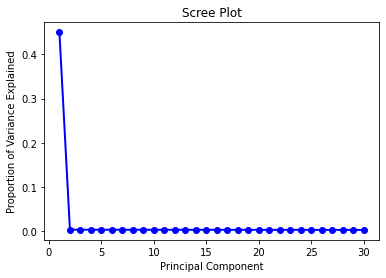

In [66]:
PC_values = numpy.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'bo-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.show()

In [67]:
print ("Proportion of Variance Explained : ", pca.explained_variance_ratio_)  
    
out_sum = numpy.cumsum(pca.explained_variance_ratio_)  
print ("Cumulative Prop. Variance Explained: ", out_sum)

Proportion of Variance Explained :  [0.4502719  0.00297385 0.00292436 0.00286853 0.00285584 0.00284474
 0.00281038 0.00278635 0.00277018 0.00274641 0.00273025 0.00271652
 0.00270188 0.00265605 0.00263309 0.00261859 0.00260074 0.0025943
 0.00256433 0.00255712 0.00254788 0.00252503 0.0025159  0.00248653
 0.00247855 0.00245859 0.00245086 0.00241764 0.00240925 0.00239943]
Cumulative Prop. Variance Explained:  [0.4502719  0.45324576 0.4561701  0.45903865 0.46189448 0.46473923
 0.46754962 0.47033596 0.47310615 0.47585255 0.4785828  0.4812993
 0.4840012  0.48665723 0.48929033 0.4919089  0.49450964 0.49710393
 0.49966827 0.5022254  0.50477326 0.5072983  0.5098142  0.5123007
 0.51477927 0.51723784 0.5196887  0.52210635 0.5245156  0.5269151 ]


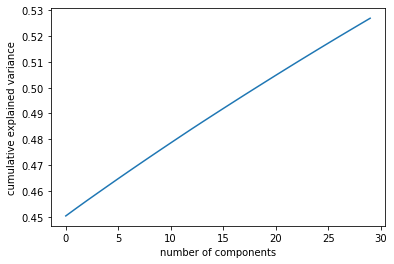

In [68]:
plt.plot(numpy.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [69]:
# eignevalues are stored in explained_variance attribute 

print(pca.explained_variance_)

[2.2822751e-04 1.5073423e-06 1.4822592e-06 1.4539593e-06 1.4475280e-06
 1.4419002e-06 1.4244838e-06 1.4123069e-06 1.4041105e-06 1.3920611e-06
 1.3838686e-06 1.3769097e-06 1.3694906e-06 1.3462629e-06 1.3346234e-06
 1.3272727e-06 1.3182256e-06 1.3149637e-06 1.2997698e-06 1.2961158e-06
 1.2914335e-06 1.2798522e-06 1.2752241e-06 1.2603377e-06 1.2562922e-06
 1.2461778e-06 1.2422601e-06 1.2254176e-06 1.2211685e-06 1.2161910e-06]


1. Principal Component Analysis is a method that is used to reduce the dimensionality of large data sets while preserving as much information as possible.

2. The goal of PCA is to preserve as much variance in data. Principal components are vectors that have maximum variation of data.

3. 30 principal components were considered and this covers only 53% of the total variance of the data.

4. From the scree plot it is evident that the first principal component accounts for 45% of the variance and the rest of principal components each accounts for very less % of variance.

5. We could consider taking the principal components whose eigenvalues are greater than one.  The eigenvalues are sum of squares of the distance between the projected data points and the origin along an eigenvector associated with a principal component. However, in our case none of the eigenalues has value greater than one.

6. Hence, PCA might not be the best method for dimensionality reduction considering this dataset.

## [CM2]: Part 3

Using test embeddings (as suggested in post @551 of Piazza) for pairs plot

In [70]:
# using the same PCA object to transform the test embeddings
Principal_components=pca.transform(test_embed)

In [71]:
new_vectors=Principal_components[:,:4]
pca_df = pd.DataFrame(data = new_vectors, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4'])
print(pca_df)

          PC 1      PC 2      PC 3      PC 4
0     0.000673 -0.000545  0.000302 -0.001353
1    -0.002029 -0.000659  0.000493  0.000396
2    -0.004755 -0.000209 -0.000474 -0.000383
3    -0.005727 -0.000889 -0.000656  0.001362
4     0.047219  0.000712 -0.001476  0.001342
...        ...       ...       ...       ...
1476  0.016285 -0.000047 -0.000738 -0.001869
1477 -0.000123  0.000453 -0.000039  0.000453
1478  0.034480 -0.001616 -0.001168 -0.001270
1479 -0.007700 -0.000210 -0.000659 -0.000692
1480 -0.002502  0.000622  0.001516  0.001442

[1481 rows x 4 columns]


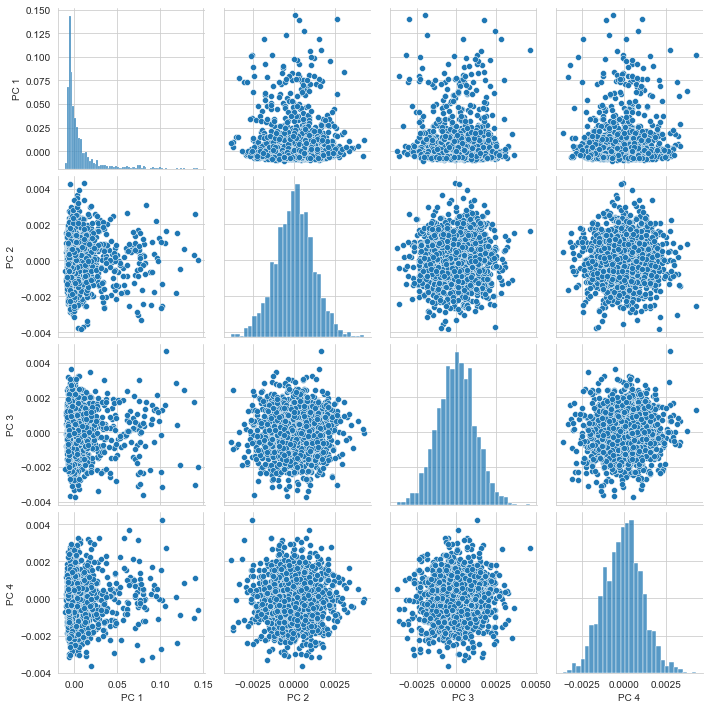

In [72]:
sns.set_style("whitegrid")
sns.pairplot(pca_df);

From the above pairs plot we notice that the subplots between PC1 and PC2, PC3, PC4 shows more variance

In [73]:
pca_dict_test={}
j=0
for i in list_words_test:
    pca_dict_test[i]=Principal_components[j]
    j+=1

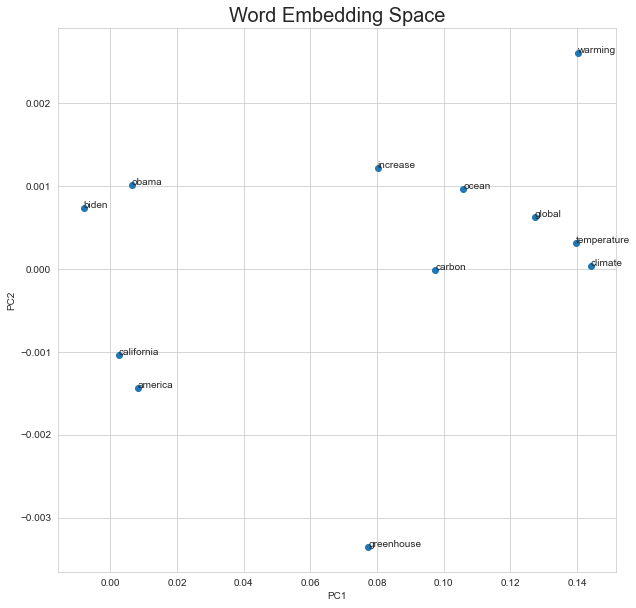

In [145]:
list_pca = ["carbon","global","warming","greenhouse","increase","temperature","ocean","climate","california","america","obama","biden"]
    
list_pca_embed=[]    
for i in list_pca:
    list_pca_embed.append(pca_dict_test[i])
    
list_pca_embed_f=numpy.array(list_pca_embed)   
plt.figure(figsize=(10,10))
plt.scatter(list_pca_embed_f[:, 0], list_pca_embed_f[:, 1])
plt.xlabel("PC1",size=10)
plt.ylabel("PC2",size=10)
plt.title("Word Embedding Space",size=20)
plt.show;
words = list_pca
for i, word in enumerate(words):
    plt.annotate(word, xy=(list_pca_embed_f[i, 0], list_pca_embed_f[i, 1]))

From the analysis on the test embedding using PCA, we notice that the similarity/dissimilarity between the words of the test embeddings are intact even though the dimensionality was reduced.

### Compare the PCA embeddings with Word2Vec embeddings

In [75]:
pca_similarity = round(cosine_similarity(pca_dict_test['carbon'], pca_dict_test['global']),2)
w2v_similarity = round(cosine_similarity(whole_dict['carbon'], whole_dict['global']),2)
print("Cosine similarity between 'carbon' and 'global' using PCA embeddings: " + str(pca_similarity))
print("Cosine similarity between 'carbon' and 'global' using Word2Vec embeddings: " + str(w2v_similarity))

Cosine similarity between 'carbon' and 'global' using PCA embeddings: 1.0
Cosine similarity between 'carbon' and 'global' using Word2Vec embeddings: 0.98


In [76]:
pca_similarity = round(cosine_similarity(pca_dict_test['polar'], pca_dict_test['ice']),2)
w2v_similarity = round(cosine_similarity(whole_dict['polar'], whole_dict['ice']),2)
print("Cosine similarity between 'polar' and 'ice' using PCA embeddings: " + str(pca_similarity))
print("Cosine similarity between 'polar' and 'ice' using Word2Vec embeddings: " + str(w2v_similarity))

Cosine similarity between 'polar' and 'ice' using PCA embeddings: 0.98
Cosine similarity between 'polar' and 'ice' using Word2Vec embeddings: 0.94


In [77]:
pca_similarity = round(cosine_similarity(pca_dict_test['sea'], pca_dict_test['rise']),2)
w2v_similarity = round(cosine_similarity(whole_dict['sea'], whole_dict['rise']),2)
print("Cosine similarity between 'sea' and 'rise' using PCA embeddings: " + str(pca_similarity))
print("Cosine similarity between 'sea' and 'rise' using Word2Vec embeddings: " + str(w2v_similarity))

Cosine similarity between 'sea' and 'rise' using PCA embeddings: 0.99
Cosine similarity between 'sea' and 'rise' using Word2Vec embeddings: 0.97


In [78]:
pca_similarity = round(cosine_similarity(pca_dict_test['bat'], pca_dict_test['pluto']),2)
w2v_similarity = round(cosine_similarity(whole_dict['bat'], whole_dict['pluto']),2)
print("Cosine similarity between 'bat' and 'pluto' using PCA embeddings: " + str(pca_similarity))
print("Cosine similarity between 'bat' and 'pluto' using Word2Vec embeddings: " + str(w2v_similarity))

Cosine similarity between 'bat' and 'pluto' using PCA embeddings: -0.24
Cosine similarity between 'bat' and 'pluto' using Word2Vec embeddings: 0.15


We have calculated the cosine similarity for similar & dissimilar context words and above are the results. We noticed that though all the 30 principal components cover only the 53% of the total variance of the data, the PCA embeddings turned out to better than Word2vec embeddings.

## Question 2
## [CM3]: Part 2: LLE

In [79]:
from sklearn.manifold import LocallyLinearEmbedding

In [80]:
lle_embedding = LocallyLinearEmbedding(n_components=4)

Using test embeddings (as suggested in post @551 of Piazza) for training and testing

In [81]:
test_embed_transformed = lle_embedding.fit_transform(test_embed)

In [82]:
test_embed_transformed

array([[ 0.00704919, -0.00507693, -0.00414818,  0.00012542],
       [ 0.00707418, -0.00594077, -0.01234145, -0.00218946],
       [ 0.00712876, -0.00562609, -0.01213001, -0.00234891],
       ...,
       [-0.0050463 ,  0.06748179,  0.06064058, -0.00552588],
       [ 0.00711249, -0.00600325, -0.01498026, -0.00312421],
       [ 0.00705853, -0.00603952, -0.01251353, -0.00217772]])

In [83]:
lle_dict_test={}
j=0
for i in list_words_test:
    lle_dict_test[i]=test_embed_transformed[j]
    j+=1

We notice that after applying LLE with dimensionality 4, number of dimensions of the word 'filter' in test embedding has been reduced to 4 from 300.

In [84]:
len(lle_dict_test['filter'])

4

In [85]:
len(whole_dict['filter'])

300

## [CM3] Part 2

In [86]:
new_vectors=test_embed_transformed[:,:4]
LLE_df = pd.DataFrame(data = new_vectors, columns = ['LLE 1', 'LLE 2', 'LLE 3', 'LLE 4'])
print(LLE_df)

         LLE 1     LLE 2     LLE 3     LLE 4
0     0.007049 -0.005077 -0.004148  0.000125
1     0.007074 -0.005941 -0.012341 -0.002189
2     0.007129 -0.005626 -0.012130 -0.002349
3     0.007068 -0.006209 -0.014566 -0.002813
4    -0.042996  0.151024 -0.061291 -0.026989
...        ...       ...       ...       ...
1476  0.006927  0.002319  0.043995  0.011299
1477  0.007077 -0.005490 -0.008270 -0.001023
1478 -0.005046  0.067482  0.060641 -0.005526
1479  0.007112 -0.006003 -0.014980 -0.003124
1480  0.007059 -0.006040 -0.012514 -0.002178

[1481 rows x 4 columns]


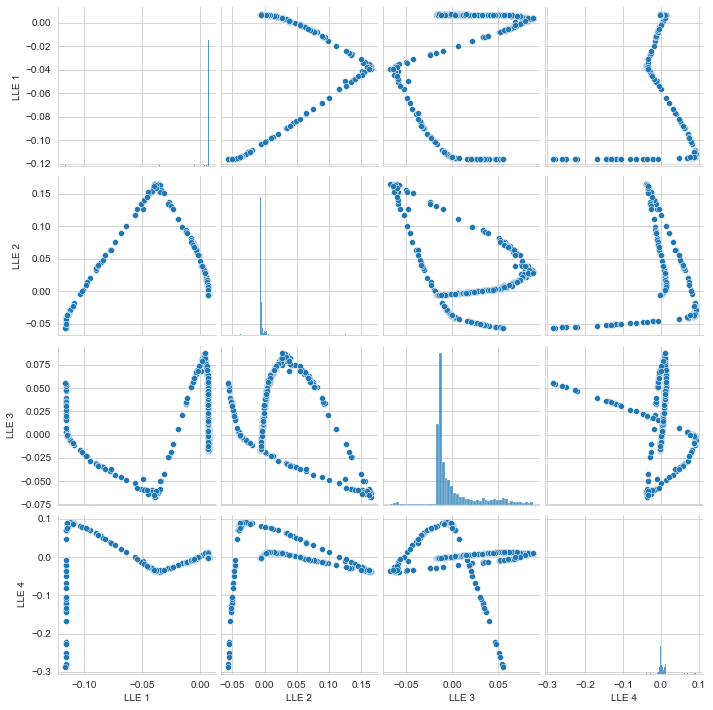

In [87]:
sns.set_style("whitegrid")
sns.pairplot(LLE_df);

LLE constructs a set of local geometric patches on each of which a sample is reconstructed through the weighted sum of its K nearest neighbours and maps these patches into a lower dimensional space.

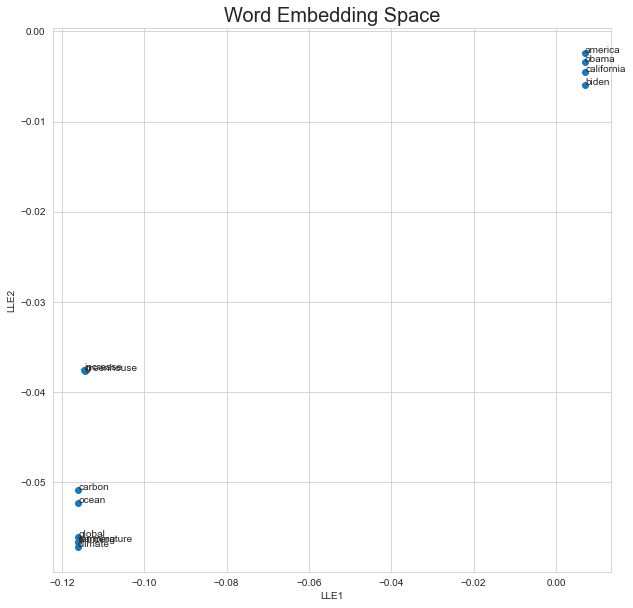

In [146]:
list_lle = ["carbon","global","warming","greenhouse","increase","temperature","ocean","climate","california","america","obama","biden"]
    
list_lle_embed=[]    
for i in list_lle:
    list_lle_embed.append(lle_dict_test[i])
    
list_lle_embed_f=numpy.array(list_lle_embed)   
plt.figure(figsize=(10,10))
plt.scatter(list_lle_embed_f[:, 0], list_lle_embed_f[:, 1])
plt.xlabel("LLE1",size=10)
plt.ylabel("LLE2",size=10)
plt.title("Word Embedding Space",size=20)
plt.show;
words = list_pca
for i, word in enumerate(words):
    plt.annotate(word, xy=(list_lle_embed_f[i, 0], list_lle_embed_f[i, 1]))

From the above scatter plot with words from test set, we notice that the similarity/dissimilarity between the words of the test embeddings are even more intact compared to PCA after the dimensionality reduction.
LLE preserves distances within local neighborhoods and the above plot clearly shows that.

### Compare the LLE embeddings with Word2Vec embeddings

In [89]:
lle_similarity = round(cosine_similarity(lle_dict_test['temperature'], lle_dict_test['global']),2)
w2v_similarity = round(cosine_similarity(whole_dict['temperature'], whole_dict['global']),2)
print("Cosine similarity between 'temperature' and 'global' using LLE embeddings: " + str(lle_similarity))
print("Cosine similarity between 'temperature' and 'global' using Word2Vec embeddings: " + str(w2v_similarity))

Cosine similarity between 'temperature' and 'global' using LLE embeddings: 1.0
Cosine similarity between 'temperature' and 'global' using Word2Vec embeddings: 0.98


In [147]:
lle_similarity = round(cosine_similarity(lle_dict_test['increase'], lle_dict_test['greenhouse']),2)
w2v_similarity = round(cosine_similarity(whole_dict['increase'], whole_dict['greenhouse']),2)
print("Cosine similarity between 'increase' and 'greenhouse' using LLE embeddings: " + str(lle_similarity))
print("Cosine similarity between 'increase' and 'greenhouse' using Word2Vec embeddings: " + str(w2v_similarity))

Cosine similarity between 'increase' and 'greenhouse' using LLE embeddings: 1.0
Cosine similarity between 'increase' and 'greenhouse' using Word2Vec embeddings: 0.95


In [148]:
lle_similarity = round(cosine_similarity(lle_dict_test['sea'], lle_dict_test['rise']),2)
w2v_similarity = round(cosine_similarity(whole_dict['sea'], whole_dict['rise']),2)
print("Cosine similarity between 'sea' and 'rise' using LLE embeddings: " + str(lle_similarity))
print("Cosine similarity between 'sea' and 'rise' using Word2Vec embeddings: " + str(w2v_similarity))

Cosine similarity between 'sea' and 'rise' using LLE embeddings: 0.75
Cosine similarity between 'sea' and 'rise' using Word2Vec embeddings: 0.97


In [92]:
lle_similarity = round(cosine_similarity(lle_dict_test['biden'], lle_dict_test['carbon']),2)
w2v_similarity = round(cosine_similarity(whole_dict['biden'], whole_dict['carbon']),2)
print("Cosine similarity between 'biden' and 'carbon' using LLE embeddings: " + str(lle_similarity))
print("Cosine similarity between 'biden' and 'carbon' using Word2Vec embeddings: " + str(w2v_similarity))

Cosine similarity between 'biden' and 'carbon' using LLE embeddings: -0.23
Cosine similarity between 'biden' and 'carbon' using Word2Vec embeddings: 0.04


We have calculated the cosine similarity for similar & dissimilar context words and above are the results. We noticed that LLE embeddings turned out to better than Word2vec embeddings in differentiating similar and dissimilar words. For instance consider the last example, words "biden" and "carbon" are dissimilar. Similarity score of LLE embeddings are far better and improved compared to word2vec embeddings.

Comparing the word embedding space (scatter plots) of PCA and LLE, LLE performed better than PCA in differentiating similar and dissimilar words.

## Question 2
## [CM4]: Part 3: t-SNE

t-SNE : It is a non-linear dimensionality reduction (DR) technique which is well suited for embedding higher dimensional data into lower dimensional data (3D or 2D) for data visualization.

Also t-SNE, models the probability distribution of neighbours around every point. Here, neighbours refer to set of points which are closer to each point. In the high-dimensional space it is modeled as a gaussian distribution. In the 2D output space, this is modeled as a t-distribution. The goal is to find a mapping onto 2D space that minimizes the differences b/w these two distributions over all the points. The fatter tails of a t-distribution when compared to a gaussian distribution help to spread the points more evenly in the 2D space.

t-SNE is widely used for visualizing data and we can only see things up to 3 dimensions and hence we choose 2 as number of components here for analysis which is hopefully the best representation of high dimensional space.

In [93]:
from sklearn.manifold import TSNE

In [94]:
tsne = TSNE(n_components=2, random_state=0)
tsne_test= tsne.fit_transform(test_embed)

In [95]:
tsne_dict_test={}
j=0
for i in list_words_test:
    tsne_dict_test[i]=tsne_test[j]
    j+=1

We notice that after applying t-SNE, number of dimensions of the word 'filter' in test embedding has been reduced to 2 from 300.

In [96]:
len(tsne_dict_test['filter'])

2

In [97]:
len(whole_dict['filter'])

300

In [98]:
TSNE_df = pd.DataFrame(data = tsne_test, columns = ['TSNE 1', 'TSNE 2'])
print(TSNE_df)

         TSNE 1     TSNE 2
0     -0.522752  -8.190365
1      9.168063  -8.340389
2      9.080200   8.037386
3     15.981693   5.667368
4    -36.256260 -34.355316
...         ...        ...
1476 -29.090422 -10.317903
1477  -0.487987   1.399815
1478 -34.431934 -27.705408
1479  17.397728  18.938213
1480   5.814171  -0.825527

[1481 rows x 2 columns]


### Visualizing the t-SNE embeddings

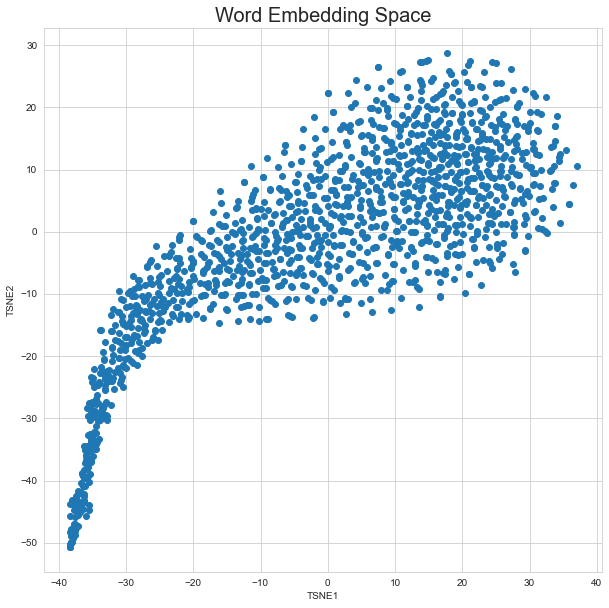

In [155]:
plt.figure(figsize=(10,10))
plt.scatter(tsne_test[:, 0], tsne_test[:, 1])
plt.xlabel("TSNE1",size=10)
plt.ylabel("TSNE2",size=10)
plt.title("Word Embedding Space",size=20)
plt.show;

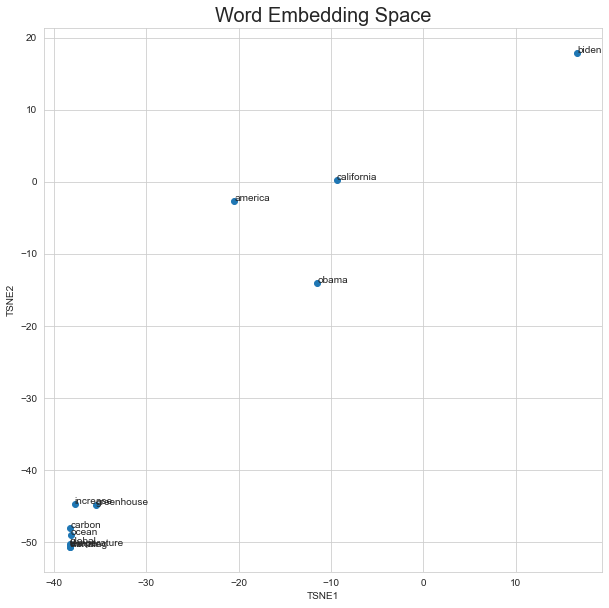

In [151]:
list_sne = ["carbon","global","warming","greenhouse","increase","temperature","ocean","climate","california","america","obama","biden"]
    
list_sne_embed=[]    
for i in list_sne:
    list_sne_embed.append(tsne_dict_test[i])
    
list_sne_embed_f=numpy.array(list_sne_embed)   
plt.figure(figsize=(10,10))
plt.scatter(list_sne_embed_f[:, 0], list_sne_embed_f[:, 1])
plt.xlabel("TSNE1",size=10)
plt.ylabel("TSNE2",size=10)
plt.title("Word Embedding Space",size=20)
plt.show;
words = list_pca
for i, word in enumerate(words):
    plt.annotate(word, xy=(list_sne_embed_f[i, 0], list_sne_embed_f[i, 1]))

t-SNE focuses on local structure of data and will try to extract clustered local groups of samples. And one such cluster can be seen in the above scatter plot where similar words are clustered together as a group.

### Compare the t-SNE embeddings with Word2Vec embeddings

In [100]:
tsne_similarity = round(cosine_similarity(tsne_dict_test['temperature'], tsne_dict_test['global']),2)
w2v_similarity = round(cosine_similarity(whole_dict['temperature'], whole_dict['global']),2)
print("Cosine similarity between 'temperature' and 'global' using tsne embeddings: " + str(tsne_similarity))
print("Cosine similarity between 'temperature' and 'global' using Word2Vec embeddings: " + str(w2v_similarity))

Cosine similarity between 'temperature' and 'global' using tsne embeddings: 1.0
Cosine similarity between 'temperature' and 'global' using Word2Vec embeddings: 0.98


In [102]:
tsne_similarity = round(cosine_similarity(tsne_dict_test['increase'], tsne_dict_test['greenhouse']),2)
w2v_similarity = round(cosine_similarity(whole_dict['increase'], whole_dict['greenhouse']),2)
print("Cosine similarity between 'increase' and 'greenhouse' using tsne embeddings: " + str(tsne_similarity))
print("Cosine similarity between 'increase' and 'greenhouse' using Word2Vec embeddings: " + str(w2v_similarity))

Cosine similarity between 'increase' and 'greenhouse' using tsne embeddings: 1.0
Cosine similarity between 'increase' and 'greenhouse' using Word2Vec embeddings: 0.95


In [108]:
tsne_similarity = round(cosine_similarity(tsne_dict_test['sea'], tsne_dict_test['rise']),2)
w2v_similarity = round(cosine_similarity(whole_dict['sea'], whole_dict['rise']),2)
print("Cosine similarity between 'sea' and 'rise' using tsne embeddings: " + str(tsne_similarity))
print("Cosine similarity between 'sea' and 'rise' using Word2Vec embeddings: " + str(w2v_similarity))

Cosine similarity between 'sea' and 'rise' using tsne embeddings: 1.0
Cosine similarity between 'sea' and 'rise' using Word2Vec embeddings: 0.97


In [104]:
tsne_similarity = round(cosine_similarity(tsne_dict_test['biden'], tsne_dict_test['carbon']),2)
w2v_similarity = round(cosine_similarity(whole_dict['biden'], whole_dict['carbon']),2)
print("Cosine similarity between 'biden' and 'carbon' using tsne embeddings: " + str(tsne_similarity))
print("Cosine similarity between 'biden' and 'carbon' using Word2Vec embeddings: " + str(w2v_similarity))

Cosine similarity between 'biden' and 'carbon' using tsne embeddings: -1.0
Cosine similarity between 'biden' and 'carbon' using Word2Vec embeddings: 0.04


The cosine similarity for similar & dissimilar context words are calculated above. 
We noticed that t-SNE embeddings turned out to better than Word2vec embeddings in differentiating similar and dissimilar words. For instance consider the last example, words "biden" and "carbon" are highly dissimilar. Similarity score of t-sne embeddings are far better and improved compared to word2vec embeddings.